In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image = cv2.imread('img.jpg')

cv2_imshow(image)

height, width, channels = image.shape
print(f'Image Size: {width}x{height}')

total_pixels = height * width * channels
print(f'Total Pixels: {total_pixels}')

#BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imwrite('image_rgb.jpg', image_rgb)

#Grayscale
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
cv2.imwrite('image_gray.jpg', image_gray)
cv2_imshow(image_gray)

height, width = image_gray.shape
print(f'Image Size: {width}x{height}')
total_pixels = height * width
print(f'Total Pixels: {total_pixels}')

_, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY)
cv2.imwrite('image_binary.jpg', image_binary)
cv2_imshow(image_binary)

black_pixel_count = np.sum(image_binary == 0)
height, width = image_binary.shape
print(f'Image Size: {width}x{height}')
total_pixels = height * width
print(f'Total Pixels: {total_pixels}')
print(f'Black Pixel Count: {black_pixel_count}')


Output hidden; open in https://colab.research.google.com to view.

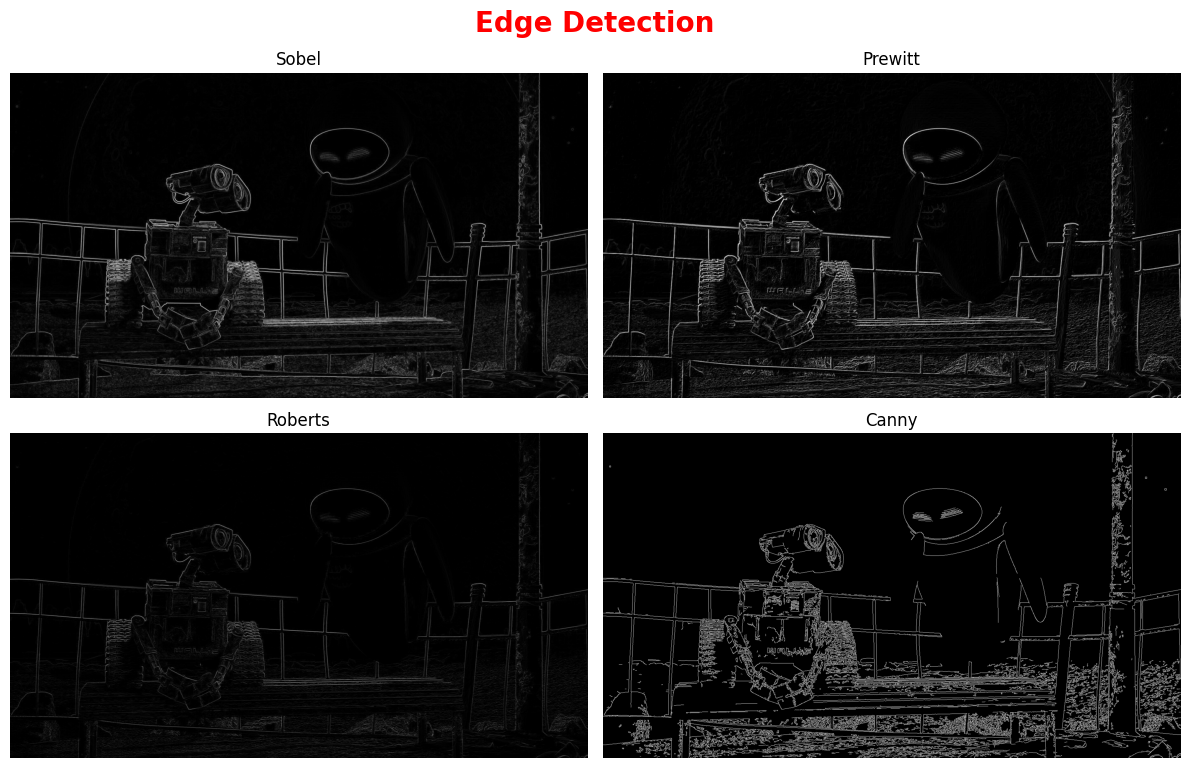

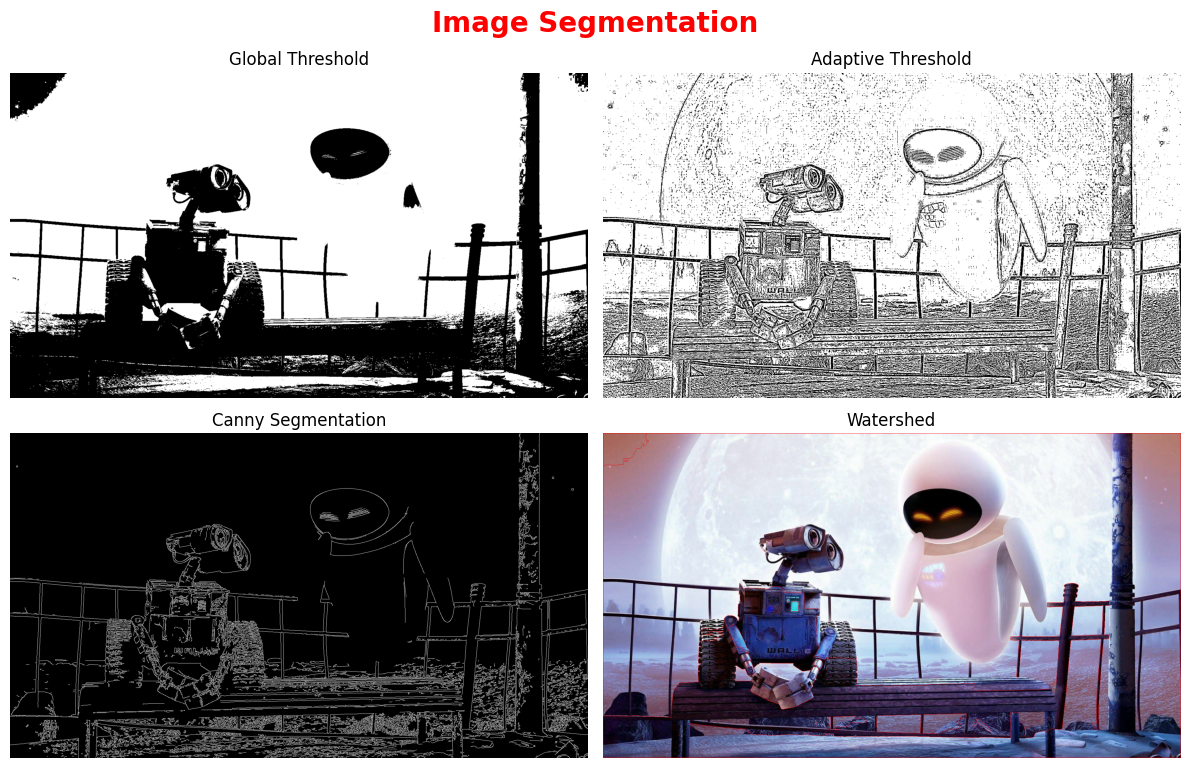

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_images(images, titles, section_title, cmap='gray'):
    plt.figure(figsize=(12, 8))
    plt.suptitle(section_title, fontsize=20, fontweight='bold', color='red')
    rows = (len(images) + 1) // 2  # Arrange in 2 columns
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, 2, i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load image
image_path = 'img.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Edge Detection
edges = {
    'Sobel': cv2.magnitude(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3),
                           cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)),
    'Prewitt': cv2.magnitude(
        cv2.filter2D(image, -1, np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])).astype(np.float32),
        cv2.filter2D(image, -1, np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])).astype(np.float32)),
    'Roberts': cv2.magnitude(
        cv2.filter2D(image, -1, np.array([[1, 0], [0, -1]])).astype(np.float32),
        cv2.filter2D(image, -1, np.array([[0, 1], [-1, 0]])).astype(np.float32)),
    'Canny': cv2.Canny(image, 100, 200)
}

show_images(list(edges.values()), list(edges.keys()), 'Edge Detection')

# Image Segmentation
_, global_thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
edges_seg = cv2.Canny(image, 100, 200)

# Watershed Segmentation
image_color = cv2.imread(image_path)
gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
cv2.watershed(image_color, markers)
image_color[markers == -1] = [255, 0, 0]

show_images([global_thresh, adaptive_thresh, edges_seg, image_color],
            ['Global Threshold', 'Adaptive Threshold', 'Canny Segmentation', 'Watershed'], 'Image Segmentation')
